In [56]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [57]:
columns = ['x_col']
df_images = pd.DataFrame(columns=columns)
df_masks = pd.DataFrame(columns=columns)

trainval_path = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\annotations\\trainval.txt'
test_path = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\annotations\\test.txt'

def get_image_mask_df(path):
    f = open(trainval_path,'r')
    image_names = []
    mask_names = []
    for i in f:
        image_name = i.split(' ')[0]
        image_names.append(['images\\'+ image_name + '.jpg'])
        mask_names.append(['annotations\\trimaps\\' + image_name+'.png'])
    
    
    df_images = pd.DataFrame(image_names,columns = columns)
    df_masks = pd.DataFrame(mask_names,columns = columns)
    return df_images, df_masks
df_train_images, df_train_masks = get_image_mask_df(trainval_path)
df_test_images, df_test_masks = get_image_mask_df(test_path)

In [58]:
def clamp(input_tensor, num_bits=4):
    input_tensor = tf.clip_by_value(input_tensor, clip_value_min=0, clip_value_max=2 ** (num_bits) - 1)
    input_tensor = ((tf.math.round(input_tensor * 2 ** (num_bits)))) / 2 ** (num_bits)
    return input_tensor


def to_fixed_point(input_tensor, ibits, fbits):
    input_tensor_i = tf.math.sign(input_tensor) * clamp(tf.floor(tf.abs(input_tensor)), ibits)
    input_tensor_f = tf.math.sign(input_tensor) * clamp(tf.math.abs(input_tensor) - tf.floor(tf.math.abs(input_tensor)), fbits)
    return input_tensor_i + input_tensor_f

@tf.custom_gradient
def quantize(x):
    y = to_fixed_point(x, ibits=6, fbits=4)

    def _fixed_point_grad(dy):
        grad = dy
        return grad

    return y, _fixed_point_grad


class QuantizeLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(QuantizeLayer, self).__init__()

    def call(self, x):
        return quantize(x)

In [59]:
print(df_train_images.head())
print(df_train_masks.head())

                       x_col
0  images\Abyssinian_100.jpg
1  images\Abyssinian_101.jpg
2  images\Abyssinian_102.jpg
3  images\Abyssinian_103.jpg
4  images\Abyssinian_104.jpg
                                    x_col
0  annotations\trimaps\Abyssinian_100.png
1  annotations\trimaps\Abyssinian_101.png
2  annotations\trimaps\Abyssinian_102.png
3  annotations\trimaps\Abyssinian_103.png
4  annotations\trimaps\Abyssinian_104.png


In [60]:
def preprocess_image(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image
def preprocess_mask(input_mask):
    input_mask -= 1
    return input_mask

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [61]:
batch_size = 32

In [62]:
diabetes_directory_images = 'C:\\Users\\tayyabm\\Downloads\\\Diabetes_Segmentation\\Original_Images\\Training_Set'
diabetes_directory_masks = 'C:\\Users\\tayyabm\\Downloads\\Diabetes_Segmentation\\All_Segmentation_Groundtruths\\Training_Set\\Microaneurysms'

In [63]:
cats_directory = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation'

image_data_gen = ImageDataGenerator(preprocessing_function=preprocess_image)
mask_data_gen = ImageDataGenerator(preprocessing_function=preprocess_mask)
# train_image_generator = image_data_gen.flow_from_directory(diabetes_directory_images,target_size=(128,128),class_mode=None,shuffle=False,seed=0)
# train_mask_generator = image_data_gen.flow_from_directory(diabetes_directory_masks,target_size=(128,128),class_mode=None,shuffle=False,seed=0)
train_image_generator = image_data_gen.flow_from_dataframe(dataframe=df_train_images,x_col='x_col',directory=cats_directory,class_mode=None,target_size=(128,128),batch_size=batch_size, shuffle=False)
train_mask_generator = mask_data_gen.flow_from_dataframe(dataframe=df_train_masks,x_col='x_col',directory=cats_directory,class_mode=None,target_size=(128,128),batch_size=batch_size, shuffle=False)

Found 3680 validated image filenames.
Found 3680 validated image filenames.


In [64]:
sample_image = tf.keras.preprocessing.image.array_to_img(train_image_generator.next()[0])
sample_mask = tf.keras.preprocessing.image.array_to_img(train_mask_generator.next()[0])

In [65]:
len(train_image_generator)

115

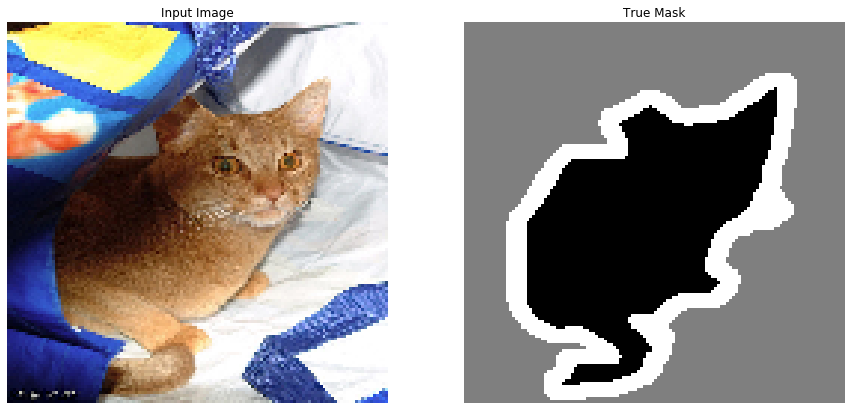

In [66]:
display([sample_image,sample_mask])

In [67]:
train_generator = zip(train_image_generator, train_mask_generator)

In [68]:
TRAIN_LENGTH = len(train_image_generator)*batch_size
BATCH_SIZE = batch_size
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [69]:
3680/64

57.5

In [70]:
def encoding_base_block(input_tensor,filters,kernal_size,activation='relu',batch_normalization=True):
    x = input_tensor
    x = layers.Conv2D(filters=filters,kernel_size=kernal_size,padding='same',kernel_initializer='he_normal')(x)
    
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters=filters,kernel_size=kernal_size,padding='same',kernel_initializer='he_normal')(x)
    
    if batch_normalization:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

In [71]:
def generate_unet(n_filter=16,dropout=0.1,batch_normalization =True,mask_channels=1,quantization=False):
    
    
    
    # encoding/reduction section
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    x = inputs
    
    conv1 = encoding_base_block(input_tensor = x,filters=n_filter*1,kernal_size=(3,3),batch_normalization=batch_normalization)
    if quantization:
        conv1 = QuantizeLayer()(conv1)
    pool1 = layers.MaxPool2D((2, 2))(conv1)
    pool1 = layers.Dropout(dropout)(pool1)
    
    conv2 = encoding_base_block(input_tensor = pool1,filters=n_filter*2,kernal_size=(3,3),batch_normalization=batch_normalization)
    if quantization:
        conv2 = QuantizeLayer()(conv2)
    pool2 = layers.MaxPool2D((2,2))(conv2)
    if not quantization:
        pool2 = layers.Dropout(dropout)(pool2)
    
        
    
    conv3 = encoding_base_block(input_tensor = pool2,filters=n_filter*4,kernal_size=(3,3),batch_normalization=batch_normalization)
    if quantization:
        conv3 = QuantizeLayer()(conv3)
    pool3 = layers.MaxPool2D((2,2))(conv3)
    if not quantization:
        pool3 = layers.Dropout(dropout)(pool3)
    
    
    conv4 = encoding_base_block(input_tensor = pool3,filters=n_filter*8,kernal_size=(3,3),batch_normalization=batch_normalization)
    if quantization:
        conv4 = QuantizeLayer()(conv4)
    pool4 = layers.MaxPool2D((2,2))(conv4)
    if not quantization:
        pool4 = layers.Dropout(dropout)(pool4)
    
    conv5 = encoding_base_block(input_tensor=pool4,filters=n_filter*16,kernal_size=(3,3),batch_normalization=batch_normalization)
    if quantization:
        conv5 = QuantizeLayer()(conv5)
    
    up6 = layers.Conv2DTranspose(n_filter*8,(3,3),strides=(2,2),padding='same')(conv5)
    up6 = layers.concatenate([up6,conv4])
    if not quantization:
        up6 = layers.Dropout(dropout)(up6)
    conv6 = encoding_base_block(input_tensor=up6,filters=n_filter*8,kernal_size=(3,3),batch_normalization=batch_normalization)
    
    
    up7 = layers.Conv2DTranspose(n_filter*4,(3,3),strides=(2,2),padding='same')(conv6)
    up7 = layers.concatenate([up7,conv3])
    if not quantization:
        up7 = layers.Dropout(dropout)(up7)
    conv7 = encoding_base_block(input_tensor=up7,filters=n_filter*4,kernal_size=(3,3),batch_normalization=batch_normalization)
    
    up8 = layers.Conv2DTranspose(n_filter*2,(3,3),strides=(2,2),padding='same')(conv7)
    up8 = layers.concatenate([up8,conv2])
    up8 = layers.Dropout(dropout)(up8)
    conv8 = encoding_base_block(input_tensor=up8,filters=n_filter*2,kernal_size=(3,3),batch_normalization=batch_normalization)
    
    
    up9 = layers.Conv2DTranspose(n_filter*2,(3,3),strides=(2,2),padding='same')(conv8)
    up9 = layers.concatenate([up9,conv1])
    up9 = layers.Dropout(dropout)(up9)
    conv9 = encoding_base_block(input_tensor=up9,filters=n_filter,kernal_size=(3,3),batch_normalization=batch_normalization)
    
    
    outputs = layers.Conv2D(mask_channels,(1,1),activation='sigmoid')(conv9)
    
    
    model = Model(inputs = inputs,outputs = [outputs])
    
    return model

In [72]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [73]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [74]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [75]:
def dice_loss(predicted_mask,actual_mask):
    eps = 0.0001
    pflat = tf.reshape(predicted_mask,[-1])
    aflat = tf.reshape(actual_mask,[-1])
    intersection = tf.reduce_sum(pflat*aflat)
    union = tf.reduce_sum(pflat) + tf.reduce_sum(aflat)
    dice = 1 - ((2.0*intersection + eps)/(union+eps))
    return dice

In [79]:
model = None
model = generate_unet(mask_channels=1,quantization=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 512, 512, 16) 64          conv2d_38[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 512, 512, 16) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def create_mask(pred_mask):    
    pred_mask = tf.argmax(pred_mask, axis=-1)    
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print('1 cleared_until_here')
        sample_image_input = tf.keras.preprocessing.image.img_to_array(sample_image)        
        print(sample_image_input.shape)
        sample_input_image=preprocess_image(sample_image_input)
        sample_input_image = np.expand_dims(sample_input_image,axis=0)
        display([sample_image, sample_mask,create_mask(model.predict(sample_input_image))])

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print('4 clear here')
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
def tensorboard_callback():
    logdir = "logs\\scalars\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return tf.keras.callbacks.TensorBoard(log_dir=logdir)

callbacks = [ DisplayCallback(), tensorboard_callback()]

In [ ]:
train_generator = (pair for pair in train_generator)
train_generator

In [ ]:
sample_image_input = tf.keras.preprocessing.image.img_to_array(sample_image)        

sample_input_image= preprocess_image(sample_image_input)
sample_input_image = np.expand_dims(sample_input_image,axis=0)

In [ ]:
display([sample_image, sample_mask])

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 0.1*len(train_image_generator)

model_history = model.fit_generator(train_generator,epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,                          
                          callbacks=callbacks
                         )

In [ ]:
from PIL import Image

In [ ]:
im1 = Image.open('C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\annotations\\trimaps\\Abyssinian_1.png')
im2 = Image.open('C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\images\\Abyssinian_1.jpg')

In [ ]:
print(im2.format)
plt.subplot(1, 2, 1)
plt.title('mask')
plt.imshow(im1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('oriignal')
plt.imshow(im2)
plt.axis('off')


In [ ]:
plt.subplot(1, 2, 1)
plt.title('mask')
plt.imshow(im3)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('oriignal')
plt.imshow(im4)
plt.axis('off')

### UNET with PreTrained Network

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from IPython.display import clear_output
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [ ]:
def preprocess_image(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    return input_image
def preprocess_mask(input_mask):
    input_mask -= 1
    return input_mask

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
columns = ['x_col']
df_images = pd.DataFrame(columns=columns)
df_masks = pd.DataFrame(columns=columns)

trainval_path = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\annotations\\trainval.txt'
test_path = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation\\annotations\\test.txt'

def get_image_mask_df(path):
    f = open(trainval_path,'r')
    image_names = []
    mask_names = []
    for i in f:
        image_name = i.split(' ')[0]
        image_names.append(['images\\'+ image_name + '.jpg'])
        mask_names.append(['annotations\\trimaps\\' + image_name+'.png'])
    
    
    df_images = pd.DataFrame(image_names,columns = columns)
    df_masks = pd.DataFrame(mask_names,columns = columns)
    return df_images, df_masks
df_train_images, df_train_masks = get_image_mask_df(trainval_path)
df_test_images, df_test_masks = get_image_mask_df(test_path)

In [ ]:
batch_size = 32

In [ ]:
cats_directory = 'C:\\Users\\tayyabm\\Downloads\\oxford_cats_segmentation'
diabetes_directory_images = 'C:\\Users\\tayyabm\\Downloads\\\Diabetes_Segmentation\\Original_Images\\Training_Set'
diabetes_directory_masks = 'C:\\Users\\tayyabm\\Downloads\\Diabetes_Segmentation\\All_Segmentation_Groundtruths\\Training_Set\\Microaneurysms'
image_data_gen = ImageDataGenerator(preprocessing_function=preprocess_image)
mask_data_gen = ImageDataGenerator(preprocessing_function=preprocess_mask)
train_image_generator = image_data_gen.flow_from_directory(diabetes_directory_images,target_size=(128,128),class_mode=None,shuffle=False,seed=0)
train_mask_generator = image_data_gen.flow_from_directory(diabetes_directory_masks,target_size=(128,128),class_mode=None,shuffle=False,seed=0)
train_image_generator = image_data_gen.flow_from_dataframe(dataframe=df_train_images,x_col='x_col',directory=cats_directory,class_mode=None,target_size=(128,128),batch_size=batch_size, shuffle=False,seed=1)
train_mask_generator = mask_data_gen.flow_from_dataframe(dataframe=df_train_masks,x_col='x_col',directory=cats_directory,class_mode=None,target_size=(128,128),batch_size=batch_size, shuffle=False,seed=1)

In [ ]:
sample_image = tf.keras.preprocessing.image.array_to_img(train_image_generator.next()[0])
sample_mask = tf.keras.preprocessing.image.array_to_img(train_mask_generator.next()[0])
display([sample_image,sample_mask])

In [ ]:
train_generator = zip(train_image_generator, train_mask_generator)
train_generator = (pair for pair in train_generator)

In [ ]:
TRAIN_LENGTH = len(train_image_generator)*batch_size
BATCH_SIZE = batch_size
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
def create_mask(pred_mask):    
    pred_mask = tf.argmax(pred_mask, axis=-1)    
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        print('1 cleared_until_here')
        sample_image_input = tf.keras.preprocessing.image.img_to_array(sample_image)        
        print(sample_image_input.shape)
        sample_input_image=preprocess_image(sample_image_input)
        sample_input_image = np.expand_dims(sample_input_image,axis=0)
        display([sample_image, sample_mask,create_mask(model_pretrained.predict(sample_input_image))])

In [ ]:
class DisplayCallbackPre(tf.keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs=None):        
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

        
def tensorboard_callback():
    logdir = "logs\\scalars\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    return tf.keras.callbacks.TensorBoard(log_dir=logdir)

callbacks = [ DisplayCallbackPre(), tensorboard_callback()]

In [81]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[224, 224, 3], include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [82]:
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [83]:
down_stack.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [84]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [85]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [86]:
#dice loss

def dice_loss(predicted_mask,actual_mask):
    eps = 0.0001
    pflat = tf.reshape(predicted_mask,[-1])
    aflat = tf.reshape(actual_mask,[-1])
    intersection = tf.reduce_sum(pflat*aflat)
    union = tf.reduce_sum(pflat) + tf.reduce_sum(aflat)
    dice = 1 - ((2.0*intersection + eps)/(union+eps))
    return dice

In [90]:
def unet_model(output_channels):

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    x = inputs

  # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [91]:
model_pretrained = None
model_pretrained = unet_model(1)
model_pretrained.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model_pretrained.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_3 (Model)                 multiple             1841984     input_7[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         multiple             1476608     model_3[3][4]                    
__________________________________________________________________________________________________
concatenate_20 (Concatenate)    (None, 32, 32, 1088) 0           sequential[2][0]                 
                                                                 model_3[3][3]              

In [92]:
# tf.keras.utils.plot_model(model_pretrained, show_shapes=True)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 0.1*len(train_image_generator)

model_history = model_pretrained.fit_generator(train_generator,epochs=EPOCHS,
                                               steps_per_epoch=STEPS_PER_EPOCH,                       
                                               callbacks=callbacks)

### UNET with Quantization

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import Model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.losses import mean_squared_error

In [ ]:
def clamp(input_tensor, num_bits=4):
    input_tensor = tf.clip_by_value(input_tensor, clip_value_min=0, clip_value_max=2 ** (num_bits) - 1)
    input_tensor = ((tf.math.round(input_tensor * 2 ** (num_bits)))) / 2 ** (num_bits)
    return input_tensor


def to_fixed_point(input_tensor, ibits, fbits):
    input_tensor_i = tf.math.sign(input_tensor) * clamp(tf.floor(tf.abs(input_tensor)), ibits)
    input_tensor_f = tf.math.sign(input_tensor) * clamp(tf.math.abs(input_tensor) - tf.floor(tf.math.abs(input_tensor)), fbits)
    return input_tensor_i + input_tensor_f

@tf.custom_gradient
def quantize(x):
    y = to_fixed_point(x, ibits=6, fbits=4)

    def _fixed_point_grad(dy):
        grad = dy
        return grad

    return y, _fixed_point_grad


class QuantizeLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(QuantizeLayer, self).__init__()

    def call(self, x):
        return quantize(x)

#### Testing gradient for quantization function

In [ ]:
with tf.Graph().as_default() as g:
    
    
    with tf.GradientTape() as tape:
        s_2 = quantize(x)
        
    print(s_2)
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())            
        print(sess.run(tape.gradient(s_2, x)))

#### Quantization Layer Testing

In [ ]:
class QuantizationTest(Model):
    def __init__(self,kernel_size,filters,padding='same',kernel_initializer=he_normal(seed=1),quantization=False):
        super(QuantizationTest,self).__init__(name='')
#         self.inputs = Input(shape=(1,10,3))
        self.conv1 = Conv2D(filters=filters,kernel_size=kernel_size,padding=padding,kernel_initializer=kernel_initializer)
        self.quantization = quantization
        
    def call(self,input_tensor,training=False):
#         x = self.inputs(input_tensor)
#         x = self.conv1(input_tensor)
        if self.quantization:
            x = QuantizeLayer()(input_tensor)
        return x
model_test = QuantizationTest(kernel_size=(3,3),filters=1,quantization=True)

In [ ]:
input_data = 100*tf.ones(
    (1,1,3,3),
    dtype=tf.dtypes.float32,
    name=None
)
output_data = 12.5*tf.ones((1,1,3,3),dtype=tf.dtypes.float32,
    name=None)
model_test(input_data)

with tf.GradientTape() as tape:
    tape.watch(model_test.trainable_variables)
    op = model_test(input_data,training=False)
    loss = mean_squared_error(output_data, op)
grad = tape.gradient(loss,model_test.trainable_variables)
